In [1]:
from pathlib import Path
import sys

BASE_PATH = Path('../')
PATH_TO_DATA = BASE_PATH/'data'
PATH_TO_MODELS = BASE_PATH/'checkpoints'
PATH_TO_CACHE = BASE_PATH/'cache'
PATH_TO_LOGS = BASE_PATH/'logs'

PATH_TO_CACHE.mkdir(exist_ok=True, parents=True)
PATH_TO_DATA.mkdir(exist_ok=True, parents=True)
PATH_TO_MODELS.mkdir(exist_ok=True, parents=True)
PATH_TO_LOGS.mkdir(exist_ok=True, parents=True)


sys.path.append(str(BASE_PATH/'..'))

#### <b>Load Libraries</b>

In [2]:

from copy import deepcopy
from tqdm import tqdm
import time
import random
from pathlib import Path
import pickle

from PIL import Image

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import models
from torchvision import transforms
from torchvision.datasets import CIFAR10

from torch.utils.data import Dataset, DataLoader, Subset

from utils import progress_bar, load_model


from sklearn.tree import DecisionTreeClassifier


stty: 'standard input': Inappropriate ioctl for device


#### <b>Notebook Constants</b>

In [3]:
RANDOM_STATE = 42
BATCH_SIZE = 256
NUM_WORKERS = 4
DEVICE = 'cuda'
NUM_CLASSES = 10

In [4]:
def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

#### <b>Define Dataset</b>

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_aug = CIFAR10(root=PATH_TO_DATA, train=True, transform=train_transforms)
cifar10 = CIFAR10(root=PATH_TO_DATA, train=True, transform=train_transforms)

test_dataset = CIFAR10(root=PATH_TO_DATA, train=False, transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

#### <b>Training utils</b>

In [6]:
def train(model, dataloader, criterion, optimizer):
    
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):

        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(dataloader), f'Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100*correct/total:.2f}%%%')  

    return train_loss/(batch_idx+1), 100.*correct/total

def test(model, dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(dataloader), f'Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100*correct/total:.2f}%%%')  
    
    return test_loss/(batch_idx+1), 100.*correct/total


def train_model(train_inds, checkpoint_name):

    set_random_seed(RANDOM_STATE)
    
    train_dataset = Subset(cifar10_trainset, train_inds)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    learning_rate = 0.1
    max_epoch = 40

    model = models.resnet18(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)
    model = model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, max_epoch)

    list_train_loss, list_train_acc = [], []
    list_loss, list_acc = [], []
    for epoch in range(max_epoch):
        
        print(f'\nEpoch: {epoch}')

        train_loss, train_acc = train(model, train_dataloader, criterion, optimizer)
        val_loss, val_acc = test(model, test_dataloader, criterion)
        scheduler.step()
        
        list_train_loss.append(train_loss)
        list_train_acc.append(train_acc)
        list_loss.append(val_loss)
        list_acc.append(val_acc)
    
    # save checkpoint
    path_to_checkpoint = PATH_TO_MODELS/checkpoint_name
    path_to_checkpoint.mkdir(exist_ok=True, parents=True)
    torch.save(model.state_dict(), path_to_checkpoint/'state_dict.pth')

    return np.array(list_train_loss), np.array(list_train_acc), np.array(list_loss), np.array(list_acc)

#### <b>Train the "Original Model"</b>

* Train the Original model to serve as the base model for performing Machine Unlearning

In [10]:
train_inds = np.load(PATH_TO_DATA/'train_inds.npy')

train_loss, train_acc, test_loss, test_acc = train_model(train_inds, checkpoint_name='origin')


Epoch: 0
 [=======================================>]  Step: 8ms | Tot: 955ms | Loss: 2.430 | Acc: 25.37% 88/88  
 [=======================================>]  Step: 3ms | Tot: 271ms | Loss: 1.860 | Acc: 35.21% 40/40  

Epoch: 1
 [=======================================>]  Step: 8ms | Tot: 970ms | Loss: 1.813 | Acc: 36.43% 88/88  
 [=======================================>]  Step: 2ms | Tot: 268ms | Loss: 2.641 | Acc: 37.46% 40/40  

Epoch: 2
 [=======================================>]  Step: 7ms | Tot: 974ms | Loss: 1.762 | Acc: 39.44% 88/88  
 [=======================================>]  Step: 2ms | Tot: 275ms | Loss: 1.744 | Acc: 41.81% 40/40  

Epoch: 3
 [=======================================>]  Step: 7ms | Tot: 960ms | Loss: 1.587 | Acc: 42.92% 88/88  ......................................]  Step: 7ms | Tot: 26ms | Loss: 1.620 | Acc: 41.60% 4/88 ==============>.........................]  Step: 6ms | Tot: 336ms | Loss: 1.623 | Acc: 42.76% 32/88 =======================>.............

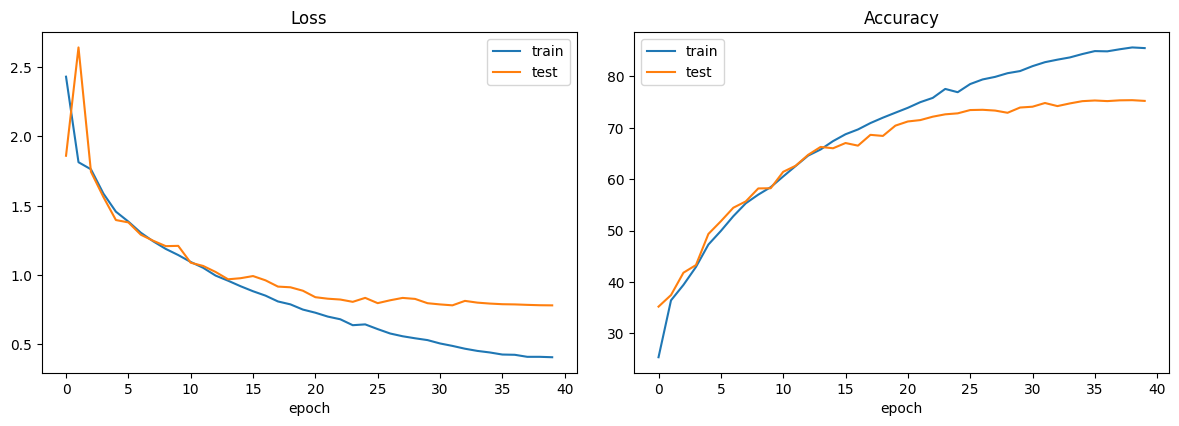

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()

axs[0].set_title('Loss')
axs[0].set_xlabel('epoch')
axs[0].plot(train_loss, label='train')
axs[0].plot(test_loss, label='test')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].set_xlabel('epoch')
axs[1].plot(train_acc, label='train')
axs[1].plot(test_acc, label='test')
axs[1].legend()

#### <b> Train the "Retrained Model"</b>
* A model trained on only the retain dataset from scratch, excluding the forget dataset.
* This model can serve as a proxy ground-truth for calculating the potential ground-truth (1) model utility and (2) forgetting score.

In [8]:
retain_inds = np.load(PATH_TO_DATA/'retain_inds.npy')

train_loss, train_acc, test_loss, test_acc = train_model(retain_inds, checkpoint_name='retrained')


Epoch: 0
 [=======================================>]  Step: 106ms | Tot: 1s174ms | Loss: 2.347 | Acc: 25.64% 84/84 
 [=======================================>]  Step: 2ms | Tot: 269ms | Loss: 2.031 | Acc: 37.15% 40/40  

Epoch: 1
 [=======================================>]  Step: 7ms | Tot: 1s106ms | Loss: 1.794 | Acc: 37.55% 84/84 
 [=======================================>]  Step: 2ms | Tot: 264ms | Loss: 2.633 | Acc: 38.69% 40/40  

Epoch: 2
 [=======================================>]  Step: 7ms | Tot: 1s40ms | Loss: 1.648 | Acc: 41.91% 84/84  
 [=======================================>]  Step: 3ms | Tot: 272ms | Loss: 1.558 | Acc: 45.24% 40/40  

Epoch: 3
 [=======================================>]  Step: 7ms | Tot: 1s66ms | Loss: 1.559 | Acc: 44.92% 84/84  
 [=======================================>]  Step: 2ms | Tot: 272ms | Loss: 1.783 | Acc: 46.39% 40/40  =====================================>..]  Step: 9ms | Tot: 266ms | Loss: 1.791 | Acc: 46.50% 38/40 

Epoch: 4
 [==========

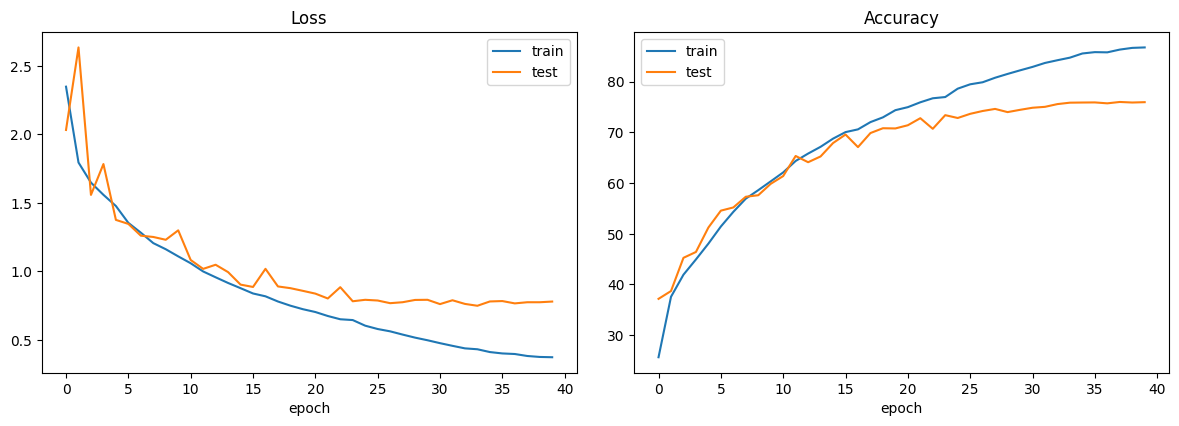

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()

axs[0].set_title('Loss')
axs[0].set_xlabel('epoch')
axs[0].plot(train_loss, label='train')
axs[0].plot(test_loss, label='test')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].set_xlabel('epoch')
axs[1].plot(train_acc, label='train')
axs[1].plot(test_acc, label='test')
axs[1].legend()

#### <b> Train the "Shadow Models"</b>
* The models which will be used for MIA

In [7]:
shadow_inds = np.load(PATH_TO_DATA/'shadow_inds.npy')

for shadow_idx in range(128):
    train_loss, train_acc, test_loss, test_acc = train_model(shadow_inds[shadow_idx], checkpoint_name=f'shadow/{shadow_idx:04}')


Epoch: 0
 [=======================================>]  Step: 59ms | Tot: 980ms | Loss: 2.767 | Acc: 20.81% 88/88 ============>...........................]  Step: 10ms | Tot: 263ms | Loss: 3.775 | Acc: 15.12% 28/88 
 [=======================================>]  Step: 29ms | Tot: 303ms | Loss: 2.086 | Acc: 24.88% 40/40 

Epoch: 1
 [=======================================>]  Step: 6ms | Tot: 1s103ms | Loss: 2.102 | Acc: 27.23% 88/88 
 [=======================================>]  Step: 2ms | Tot: 348ms | Loss: 1.835 | Acc: 32.84% 40/40  

Epoch: 2
 [=======================================>]  Step: 6ms | Tot: 963ms | Loss: 1.805 | Acc: 34.04% 88/88  
 [=======================================>]  Step: 2ms | Tot: 279ms | Loss: 1.695 | Acc: 37.25% 40/40  ==========>...........................]  Step: 4ms | Tot: 88ms | Loss: 1.691 | Acc: 37.83% 13/40 

Epoch: 3
 [=======================================>]  Step: 14ms | Tot: 984ms | Loss: 1.661 | Acc: 38.58% 88/88 
 [===============================

#### <b> Shokri MIA evaluator</b>

In [7]:
train_inds = np.load(PATH_TO_DATA/'train_inds.npy')
with open(PATH_TO_DATA/'data_split.pickle', 'rb') as file:
    data_split = pickle.load(file)
data_split = pd.DataFrame(data_split)

In [8]:
dataset = Subset(cifar10, train_inds)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
shadow_nets = [load_model(state_dict, NUM_CLASSES).to(DEVICE) for state_dict in (PATH_TO_MODELS/'shadow').glob('*/*')]
shadow_logits = [[] for _ in range(len(shadow_nets))]
dataset_labels = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        for i, net in enumerate(shadow_nets):
            logits = net(inputs).log_softmax(1).cpu().tolist()
            shadow_logits[i].append(logits)
    
        dataset_labels.append(targets.cpu().tolist())

shadow_logits = np.stack([np.concatenate(logits) for logits in shadow_logits]).reshape(-1, NUM_CLASSES)
dataset_labels = np.repeat(np.concatenate(dataset_labels)[None], len(shadow_nets), 0).reshape(-1, 1)


100%|██████████| 88/88 [00:23<00:00,  3.79it/s]


In [9]:
SAMPLE = 'sample'
TRAIN = 'train'
VALID = 'valid'
TEST = 'test'
TARGET = 'target'
PRED = 'pred'

In [220]:
df = pd.DataFrame(shadow_logits, columns = [f'feature_{i}' for i in  range(NUM_CLASSES)])

df['target'] = np.concatenate([data_split.loc[idx, train_inds].values.astype(int) for idx in range(len(shadow_nets))])
df['ce_loss'] = -shadow_logits[range(shadow_logits.shape[0]), dataset_labels.reshape(-1)]



train_index, test_valid_index = train_test_split(df.index, test_size=0.20, random_state=RANDOM_STATE)
test_index, valid_index = train_test_split(test_valid_index, test_size=0.50, random_state=RANDOM_STATE)
df.loc[train_index, SAMPLE] = TRAIN
df.loc[valid_index, SAMPLE] = VALID
df.loc[test_index, SAMPLE] = TEST

display(df)
display(df.groupby(SAMPLE)[[TARGET]].count().T)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target,ce_loss,sample
0,-6.240524,-20.603346,-0.002634,-10.290565,-7.401554,-12.026717,-12.769495,-10.458840,-17.156942,-18.578726,1,0.002634,train
1,-0.133599,-10.538504,-8.141061,-9.862561,-9.149107,-12.125355,-9.681712,-12.492629,-2.087482,-7.577177,0,0.133599,test
2,-9.980149,-10.758443,-2.593120,-8.756501,-7.719378,-11.216876,-0.078546,-9.589691,-13.402101,-13.603146,1,0.078546,train
3,-1.921887,-4.928870,-2.635596,-1.780231,-6.283439,-0.553537,-7.295737,-4.003566,-4.704854,-6.571804,0,0.553537,train
4,-3.211754,-0.138295,-7.806234,-10.807668,-9.647892,-14.700027,-12.289304,-9.616104,-6.574973,-2.442837,0,3.211754,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879995,-0.092640,-2.652458,-6.787939,-9.306932,-7.455601,-10.860615,-7.771110,-12.324215,-7.066804,-4.206015,1,0.092640,train
2879996,-7.791042,-12.615540,-5.405784,-11.703321,-0.005298,-9.121348,-10.520958,-8.698151,-10.069729,-10.669483,1,0.005298,test
2879997,-6.847296,-9.750169,-6.919836,-8.306338,-13.894094,-9.076302,-4.769791,-9.452778,-0.011177,-9.391323,0,0.011177,train
2879998,-10.433750,-11.252253,-5.087885,-0.864031,-4.517415,-0.727598,-2.630689,-5.078258,-11.895577,-9.497678,0,0.864031,train


sample,test,train,valid
target,288000,2304000,288000


In [228]:
def get_metrics(df, fnr_threshold=0.05):

    fpr, tpr, thresholds = metrics.roc_curve(df.loc[df[SAMPLE]==TRAIN, TARGET], df.loc[df[SAMPLE]==TRAIN, PRED])

    fnr = 1 - tpr
    tnr = 1 - fpr

    threshold = thresholds[np.where(fnr <= fnr_threshold)[0][0]]
    print(threshold)

    res = df.groupby(SAMPLE).apply(lambda x: metrics.confusion_matrix(x[TARGET], (x[PRED] > threshold).astype(int),normalize='true').ravel()[0])
    
    return res
    

In [226]:
FEATS = [feat for feat in df.columns if feat not in [SAMPLE, TARGET, PRED]]

In [227]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(
    df.loc[df[SAMPLE] == TRAIN, FEATS], df.loc[df[SAMPLE] == TRAIN, TARGET], 
)
df[PRED] = model.predict_proba(df[FEATS])[:, 1]

display(get_metrics(df, 0.05))

with open(PATH_TO_MODELS/'atacker.pickle', 'wb') as file:
    pickle.dump(model, file)


/tmp/ipykernel_1555023/2654818936.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = df.groupby(SAMPLE).apply(lambda x: metrics.confusion_matrix(x[TARGET], (x[PRED] > threshold).astype(int),normalize='true').ravel()[0])


sample
test     0.170102
train    0.170619
valid    0.169752
dtype: float64